In [ ]:
# Run this cell to install DiffeRT and its dependencies, e.g., on Google Colab

try:
    import differt  # noqa: F401
except ImportError:
    import sys  # noqa: F401

    !{sys.executable} -m pip install differt[all]

# Coherence Map

In [2]:
import equinox as eqx
import jax.numpy as jnp

from differt.geometry.utils import path_lengths
from differt.plotting import draw_image
from differt.scene.sionna import download_sionna_scenes, get_sionna_scene
from differt.scene.triangle_scene import TriangleScene

In [3]:
download_sionna_scenes()  # Let's download Sionna scenes (from the main branch)

RFBOutputContext()

full_paths.shape = (1, 10000, 5402, 4, 3)
path_candidates.shape = (1, 10000, 5402, 2)
objects.shape = (1, 10000, 5402, 4)


CanvasBackend(css_height='600px', css_width='800px')
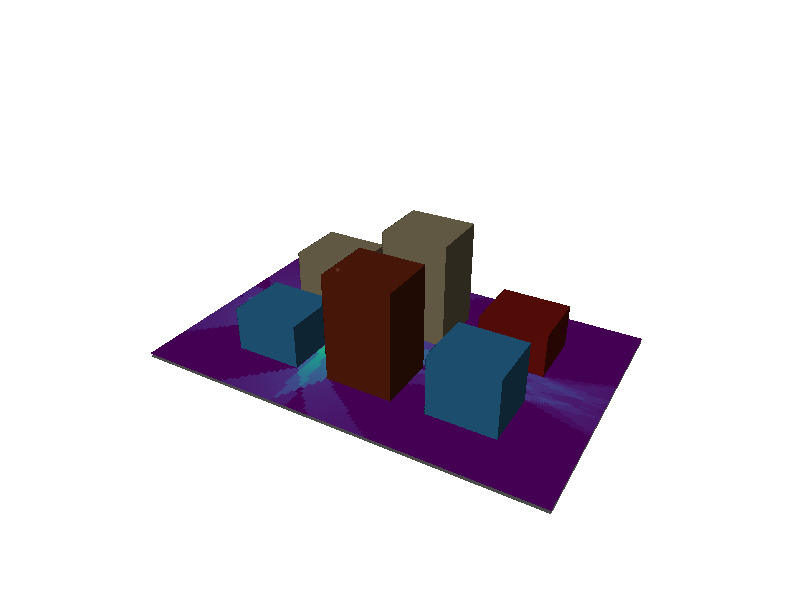

In [9]:
file = get_sionna_scene("simple_street_canyon")
scene = TriangleScene.load_xml(file)

scene = eqx.tree_at(lambda s: s.transmitters, scene, jnp.array([-33, 0, 32.0]))

(min_x, min_y, _), (max_x, max_y, _) = scene.mesh.bounding_box
x = jnp.linspace(min_x, max_x, 50)
y = jnp.linspace(min_y, max_y, 50)
x, y = jnp.meshgrid(x, y)
z0 = 1.5
z = jnp.full_like(x, z0)
rx_grid = jnp.stack((x, y, z), axis=-1)
canvas = scene.plot()
scene = eqx.tree_at(lambda s: s.receivers, scene, rx_grid)
paths = scene.compute_paths(order=2)
power = (paths.mask / path_lengths(paths.vertices) ** 2).sum(axis=-1)
draw_image(power, x=x, y=y, z0=z0, canvas=canvas)

In [8]:
paths.group_by_objects()

Array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 